In [1]:
import numpy as np
from pprint import pprint
from copy import deepcopy


from laboneq.contrib.example_helpers.generate_descriptor import generate_descriptor
#from laboneq.contrib.example_helpers.generate_device_setup import generate_device_setup
from laboneq.dsl.device import DeviceSetup
from laboneq.simple import *
from laboneq.dsl.device import DeviceSetup
from laboneq.dsl.calibration import Oscillator, SignalCalibration
from laboneq.dsl.enums import ModulationType




# descriptor = generate_descriptor(
#     #pqsc=[""], # 장비 여러개 사용시
#     shfqc_6=["DEV12256"], 
#     number_data_qubits=3,
#     multiplex=True,
#     number_multiplex=6,
#     include_cr_lines=False,
#     include_ef_lines=True,
#     get_zsync=False,  # Only set to True when using real device
#     save = True,
#     filename="1port",
#     ip_address="192.168.0.83"
# )


#descriptor
#setup = DeviceSetup.from_descriptor(yaml_text=descriptor, server_host="192.168.0.83")
setup = DeviceSetup.from_yaml(filepath="/Users/yalgaeahn/JSAHN/qubit-experiment/examples/selectiveRIP/Descriptors/1port.yaml" , server_host="192.168.0.83")
#setup
setup.instruments[0].device_options = 'SHFQC/PLUS/QC6CH'
#setup.instruments


bus_ids = [f"b{i}" for i in range(3)]
bus_port = [4,5,6] #used 1,2,3 for qubit drive

for i, bus in zip(bus_port,bus_ids):
    setup.add_connections(
        setup.instruments[0].uid,
        # each bus uses its own drive:
        create_connection(
            to_signal=f"{bus}/drive",
            ports=f"SGCHANNELS/{i}/OUTPUT"
        ))

# Calibrate qubit drive/measure lines for oscillator phase increments
qubit_ids = [uid for uid in setup.logical_signal_groups if uid.startswith("q")]
for qubit in qubit_ids:
    for line, frequency, mod_type in [
        ("drive", 5e9, ModulationType.HARDWARE),
        ("drive_ef", 6e9, ModulationType.HARDWARE),
        ("measure", 4e9, ModulationType.SOFTWARE),
    ]:
        logical_signal = setup.logical_signal_by_uid(f"{qubit}/{line}")
        oscillator = Oscillator(modulation_type=mod_type)
        logical_signal.calibration = SignalCalibration(
            local_oscillator=Oscillator(frequency=frequency),
            oscillator=oscillator,
        )
        if line == "measure":
            acquire_signal = setup.logical_signal_by_uid(f"{qubit}/acquire")
            acquire_signal.calibration = SignalCalibration(
                local_oscillator=Oscillator(frequency=frequency),
                oscillator=oscillator,
            )

from qpu_types.fixed_transmon import FixedTransmonQubit, FixedTransmonQubitParameters
from qpu_types.bus_cavity import BusCavity, BusCavityParameters
from qpu_types.fixed_transmon.operations import FixedTransmonOperations
from qpu_types.bus_cavity.operations import BusCavityOperations
from laboneq.dsl.quantum.qpu import QPU, QuantumPlatform
from helper import load_qubit_parameters, save_qubit_parameters

qubit_uids = [uid for uid in setup.logical_signal_groups if uid.startswith("q")]
bus_uids = [uid for uid in setup.logical_signal_groups if uid.startswith("b")]

qubits = FixedTransmonQubit.from_device_setup(
    setup, qubit_uids=qubit_uids)
buses = BusCavity.from_device_setup(
    setup, qubit_uids=bus_uids)

qpu = QPU(quantum_elements={"qubits" : qubits, "bus" : buses}, quantum_operations=[FixedTransmonOperations, BusCavityOperations])


# from laboneq.simple import workflow
# folder_store = workflow.logbook.FolderStore("./experiment_store") 
# folder_store.activate()
# #folder_store.deactivate()
# #workflow.logbook.LoggingStore().activate()
# #workflow.logbook.LogbookStore().deactivate()

import os
from datetime import datetime
def find_latest_json(folder_path):
    files = [f for f in os.listdir(folder_path)]
    timestamps = []
    for file in files:
        try:
            # Extract a timestamp assuming it's included in the filename
            timestamp_str = file.split('_', 1)[0]  # Assuming YYYYMMDDHHMMSS format
            timestamp = datetime.strptime(timestamp_str, '%Y%m%d-%H%M%S')
            timestamps.append((timestamp, file))
        except ValueError:
            print("fuck")
            continue  # Skip files that do not match the timestamp format

       # Find the most recent file
    if timestamps:
        latest_file = max(timestamps, key=lambda x: x[0])[1]
        return os.path.join(folder_path, latest_file)
    return None

qb_pars_file = find_latest_json("./qpu_parameters/")
print(f"LOADED: {qb_pars_file}")

from qpu_types.fixed_transmon.operations import FixedTransmonOperations
from qpu_types.bus_cavity.operations import BusCavityOperations
import laboneq.dsl.quantum.qpu as qpu_mod

class CombinedOperations(FixedTransmonOperations, BusCavityOperations):
    pass

qpu_mod.CombinedOperations = CombinedOperations

qpu = load(qb_pars_file)

buses = qpu.groups.bus
qubits = qpu.groups.qubits


from laboneq.simple import workflow
folder_store = workflow.logbook.FolderStore("./experiment_store")
folder_store.activate()

fuck
LOADED: ./qpu_parameters/20260216-1700_save_test2


# CONNECTION

In [2]:
from laboneq.simple import Session
session = Session(setup)
session.connect(ignore_version_mismatch=False, do_emulation=False)
#session.disconnect()

[2026.02.17 16:15:15.439] INFO    Logging initialized from [Default inline config in laboneq.laboneq_logging] logdir is /Users/yalgaeahn/JSAHN/qubit-experiment/examples/selectiveRIP/laboneq_output/log
[2026.02.17 16:15:15.441] INFO    VERSION: laboneq 25.10.3
[2026.02.17 16:15:15.441] INFO    Connecting to data server at 192.168.0.83:8004
[2026.02.17 16:15:15.484] INFO    Connected to Zurich Instruments LabOne Data Server version 25.10.1.4 at 192.168.0.83:8004
[2026.02.17 16:15:15.526] INFO    Configuring the device setup
[2026.02.17 16:15:15.554] INFO    The device setup is configured


# 정리된 Readout 최적화 흐름

1) Readout frequency (coarse sweep, wide)
2) Integration window (delay+length sweep)
3) Readout length sweep
4) Readout frequency (re-sweep, tighter)
5) Readout amplitude sweep
6) Readout frequency (final short convergence)

# IQ cloud

In [11]:
qubits[0].parameters.readout_length = 2.0e-6
qubits[0].parameters.readout_integration_length = 2.0e-6
qubits[1].parameters.readout_length = 2.0e-6
qubits[1].parameters.readout_integration_length = 2.0e-6
qubits[2].parameters.readout_length = 2.0e-6
qubits[2].parameters.readout_integration_length = 2.0e-6


[2026.02.17 17:59:06.948] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.17 17:59:06.949] INFO      Workflow 'iq_cloud': execution started at 2026-02-17 08:59:06.948589Z         
[2026.02.17 17:59:06.950] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.17 17:59:06.967] INFO    Task 'temporary_qpu': started at 2026-02-17 08:59:06.966951Z
[2026.02.17 17:59:06.968] INFO    Task 'temporary_qpu': ended at 2026-02-17 08:59:06.968266Z
[2026.02.17 17:59:06.971] INFO    Task 'temporary_quantum_elements_from_qpu': started at 2026-02-17 
[2026.02.17 17:59:06.971] INFO    08:59:06.970874Z
[2026.02.17 17:59:06.972] INFO    Task 'temporary_quantum_elements_from_qpu': ended at 2026-02-17 08:59:06.972231Z
[2026.02.17 17:59:06.973] INFO    Task 'create_experiment': started at 2026-02-17 08:59:06.973390Z
[2026.02.17 17:59:06.978] INFO    Task 'create_experiment': ended at 2026-02-17 08:59:06.978723Z
[202

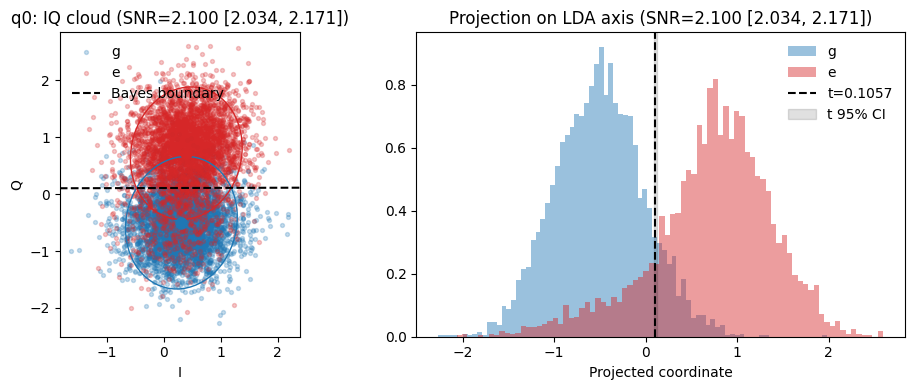

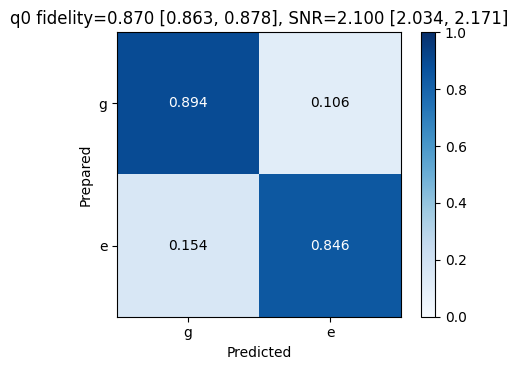

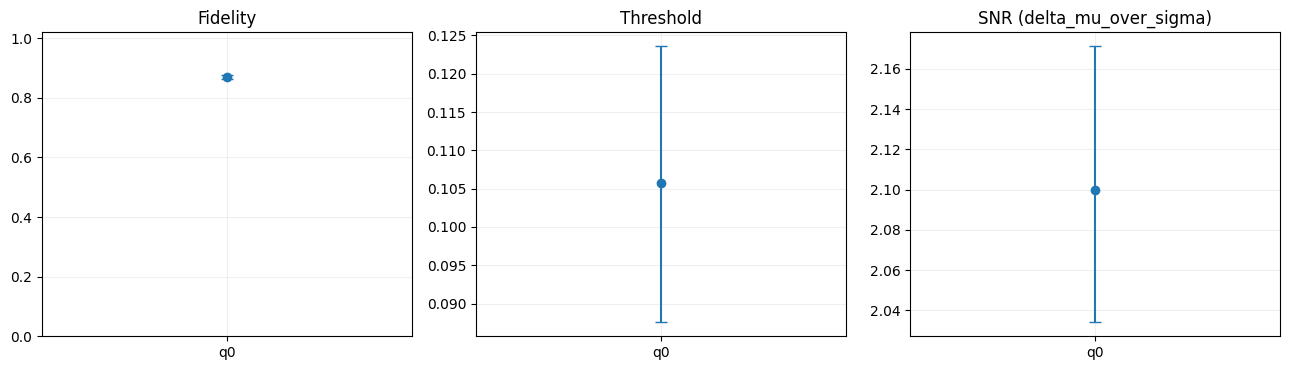

In [10]:
from experiments import iq_cloud_common, iq_cloud
q = qubits[0]

temporary_parameters = {}
q_temp_pars = deepcopy(q.parameters)
temporary_parameters[q.uid] = q_temp_pars
#######################################################################

options = iq_cloud.experiment_workflow.options()
options.do_analysis(True)
options.update(False)
#options.count(1024)

iq_result = iq_cloud.experiment_workflow(
    session=session,
    qpu=qpu,
    qubits=q,
    temporary_parameters=temporary_parameters,
    options=options,
).run()


# Dispersive Shift

In [ ]:

# from experiments import dispersive_shift

# #######################################################################
# q = qubits[0]
# temporary_parameters = {}
# temp_pars =deepcopy(q.parameters)
# temporary_parameters[q.uid] = temp_pars

# print(f"DRIVE range (dBm) : {q.parameters.drive_range}, READOUT range (dBm) : {q.parameters.readout_range_out}")
# #######################################################################
# options = dispersive_shift.experiment_workflow.options()
# options.count(1024)
# options.update(False)
# #print(workflow.show_fields(options))

# ###################################################################
# dispersive = dispersive_shift.experiment_workflow(
#     session=session,
#     qpu=qpu,
#     qubit=q,
#     frequencies=q.parameters.readout_resonator_frequency + np.linspace(-5e6,5e6,201),
#     options=options,
#     states='ge',
#     temporary_parameters=temporary_parameters
# )

# dispersive_result = dispersive.run() 
# print(dispersive_result.tasks['analysis_workflow'].output)

# Converged Readout Optimization

목표 순서: `frequency → integration window(delay+length) → readout length → frequency re-sweep → amplitude → short frequency re-sweep`

아래 셀은 이전 1~4 스텝을 한 번에 묶은 실행 예시입니다. 각 스텝은 직전 결과의 최적값을 다음 스텝의 `temporary_parameters`로 넘겨서 수렴 형태로 진행합니다.

In [ ]:
from copy import deepcopy
from pprint import pprint
import numpy as np

from experiments import (
    readout_frequency_sweep,
    readout_integration_delay_sweep,
    readout_length_sweep,
    readout_amplitude_sweep,
)


def _safe_output_unwrap(obj, max_depth: int = 16):
    seen = set()
    queue = [(obj, 0)]

    while queue:
        current, depth = queue.pop(0)
        if depth > max_depth:
            continue

        if id(current) in seen:
            continue
        if current is None:
            continue
        seen.add(id(current))

        if isinstance(current, dict):
            if "analysis_result" in current and current["analysis_result"] is not None:
                queue.append((current["analysis_result"], depth + 1))
            if "output" in current and current["output"] is not None:
                queue.append((current["output"], depth + 1))
            for value in current.values():
                queue.append((value, depth + 1))
            continue

        if hasattr(current, "output"):
            queue.append((getattr(current, "output"), depth + 1))

        if hasattr(current, "analysis_result"):
            queue.append((getattr(current, "analysis_result"), depth + 1))

        if hasattr(current, "tasks"):
            queue.append((getattr(current, "tasks"), depth + 1))

        if isinstance(current, (list, tuple)):
            queue.extend((v, depth + 1) for v in current)
            continue

    return None


def _iter_candidate_dicts(obj, max_depth: int = 20):
    seen = set()
    stack = [(obj, 0)]

    while stack:
        current, depth = stack.pop()
        if depth > max_depth:
            continue

        oid = id(current)
        if oid in seen:
            continue
        seen.add(oid)

        if current is None:
            continue

        if isinstance(current, dict):
            has_best = isinstance(current.get("best_point"), dict)
            has_quality = "quality_flag" in current
            if has_best and has_quality:
                yield current
            if "analysis_result" in current:
                stack.append((current["analysis_result"], depth + 1))
            if "output" in current:
                stack.append((current["output"], depth + 1))
            for value in current.values():
                stack.append((value, depth + 1))
            continue

        if hasattr(current, "tasks"):
            stack.append((getattr(current, "tasks"), depth + 1))
        if hasattr(current, "output"):
            stack.append((getattr(current, "output"), depth + 1))
        if hasattr(current, "analysis_result"):
            stack.append((getattr(current, "analysis_result"), depth + 1))

        if isinstance(current, (list, tuple)):
            stack.extend((v, depth + 1) for v in current)
            continue

        if hasattr(current, "__dict__"):
            d = current.__dict__
            for value in d.values():
                stack.append((value, depth + 1))


def extract_analysis_output(workflow_result):
    # 1) direct best-point dictionaries
    for candidate in _iter_candidate_dicts(workflow_result):
        return candidate

    # 2) fallback legacy behavior
    out = _safe_output_unwrap(workflow_result)
    if isinstance(out, dict) and "best_point" in out:
        return out

    tasks = getattr(workflow_result, "tasks", None)
    if tasks is not None:
        try:
            iterable = tasks.values() if hasattr(tasks, "values") else tasks
            for t in iterable:
                for candidate in _iter_candidate_dicts(t):
                    return candidate
        except Exception:
            pass

    raise RuntimeError("Could not extract analysis output containing best_point.")


def _make_temp_params(qubit, state):
    temp = deepcopy(qubit.parameters)
    for k, v in state.items():
        if hasattr(temp, k):
            setattr(temp, k, v)
    return {qubit.uid: temp}


def _q_state_from_qubit(qubit):
    return {
        "readout_resonator_frequency": float(qubit.parameters.readout_resonator_frequency),
        "readout_integration_delay": float(qubit.parameters.readout_integration_delay or 0.0),
        "readout_integration_length": float(qubit.parameters.readout_integration_length),
        "readout_length": float(qubit.parameters.readout_length),
        "readout_amplitude": float(qubit.parameters.readout_amplitude),
    }


def _append_history(history, step, analysis, detail, q):
    uid = q.uid
    best = analysis["best_point"]
    history.append(
        {
            "step": step,
            "quality": analysis["quality_flag"],
            "detail": detail,
            "best_point": best,
            "new_parameter_values": analysis["new_parameter_values"].get(uid, {}),
        }
    )


def run_readout_converged_workflow(
    q,
    qpu,
    session,
    *,
    state=None,
    freq_span_initial=1.0e6,
    freq_points_initial=13,
    freq_span_mid=250e3,
    freq_points_mid=11,
    freq_span_short=80e3,
    freq_points_short=9,
    window_delay_span=30e-9,
    window_length_factors=(0.7, 0.85, 1.0, 1.15, 1.3),
    readout_lengths=(0.5, 0.7, 0.9, 1.0, 1.2, 1.4),
    amp_frac=0.2,
    amp_points=13,
    count_freq=1024,
    count_other=512,
    do_plot=True,
    plot_iq_cloud=True,
    max_readout_length=2.048e-6,
):
    if state is None:
        state = _q_state_from_qubit(q)

    history = []

    # 1) frequency (coarse)
    center_f = state["readout_resonator_frequency"]
    freqs = np.linspace(center_f - freq_span_initial, center_f + freq_span_initial, freq_points_initial)
    opts = readout_frequency_sweep.experiment_workflow.options()
    opts.do_analysis(True)
    opts.update(False)
    opts.count(int(count_freq))
    if not do_plot:
        opts.do_plotting(False)

    wf = readout_frequency_sweep.experiment_workflow(
        session=session,
        qpu=qpu,
        qubit=q,
        frequencies=freqs,
        temporary_parameters=_make_temp_params(q, state),
        options=opts,
    )
    ana = extract_analysis_output(wf.run())
    best = ana["new_parameter_values"][q.uid]
    state.update({"readout_resonator_frequency": float(best["readout_resonator_frequency"])})
    _append_history(history, "freq-coarse", ana, f"center={center_f:.6f}Hz ± {freq_span_initial:.0f}Hz", q)

    # 2) integration delay + integration length window
    center_delay = state["readout_integration_delay"]
    center_length = state["readout_integration_length"]
    delays = np.linspace(max(0.0, center_delay - window_delay_span), center_delay + window_delay_span, 13)
    integration_lengths = np.asarray(window_length_factors, dtype=float) * center_length
    if max_readout_length is not None:
        max_delay_in_sweep = float(np.max(delays))
        integration_cap = float(max_readout_length) - max_delay_in_sweep
        if integration_cap <= 0.0:
            raise ValueError("No valid integration_length under measure-section limit.")
        integration_lengths = np.clip(integration_lengths, 0.0, integration_cap)
        integration_lengths = np.unique(integration_lengths)

    opts = readout_integration_delay_sweep.experiment_workflow.options()
    opts.do_analysis(True)
    opts.update(False)
    opts.count(int(count_other))
    if not do_plot:
        opts.do_plotting(False)

    wf = readout_integration_delay_sweep.experiment_workflow(
        session=session,
        qpu=qpu,
        qubit=q,
        delays=delays,
        integration_lengths=integration_lengths,
        temporary_parameters=_make_temp_params(q, state),
        options=opts,
    )
    ana = extract_analysis_output(wf.run())
    best = ana["new_parameter_values"][q.uid]
    state.update(
        {
            "readout_integration_delay": float(best["readout_integration_delay"]),
            "readout_integration_length": float(best["readout_integration_length"]),
        }
    )
    if max_readout_length is not None:
        max_len_for_state = float(max_readout_length) - float(state["readout_integration_delay"])
        if max_len_for_state <= 0.0:
            raise ValueError("readout_integration_delay leaves no integration window budget.")
        state["readout_integration_length"] = min(
            float(state["readout_integration_length"]),
            max_len_for_state,
        )
    _append_history(history, "integration-window", ana, "simultaneous sweep", q)

    # 3) readout length
    base_len = state["readout_length"]
    readout_length_points = np.asarray(readout_lengths, dtype=float) * base_len
    if max_readout_length is not None:
        readout_length_points = np.clip(readout_length_points, 0.0, float(max_readout_length))
        readout_length_points = np.unique(readout_length_points)
    if readout_length_points.size < 1:
        raise ValueError("No valid readout_length points after safety clipping.")
    opts = readout_length_sweep.experiment_workflow.options()
    opts.do_analysis(True)
    opts.update(False)
    opts.count(int(count_other))
    if max_readout_length is not None and hasattr(opts, "max_readout_length"):
        opts.max_readout_length(float(max_readout_length))
    if not do_plot:
        opts.do_plotting(False)

    wf = readout_length_sweep.experiment_workflow(
        session=session,
        qpu=qpu,
        qubit=q,
        readout_lengths=readout_length_points,
        temporary_parameters=_make_temp_params(q, state),
        options=opts,
    )
    ana = extract_analysis_output(wf.run())
    best = ana["new_parameter_values"][q.uid]
    state.update({"readout_length": float(best["readout_length"])})
    _append_history(history, "readout-length", ana, f"scaled factors={tuple(readout_lengths)}", q)

    # 4) re-sweep frequency around updated point
    center_f = state["readout_resonator_frequency"]
    freqs = np.linspace(center_f - freq_span_mid, center_f + freq_span_mid, freq_points_mid)
    opts = readout_frequency_sweep.experiment_workflow.options()
    opts.do_analysis(True)
    opts.update(False)
    opts.count(int(count_freq))
    if not do_plot:
        opts.do_plotting(False)
    if not plot_iq_cloud:
        opts.do_plotting_optimal_iq_cloud(False)

    wf = readout_frequency_sweep.experiment_workflow(
        session=session,
        qpu=qpu,
        qubit=q,
        frequencies=freqs,
        temporary_parameters=_make_temp_params(q, state),
        options=opts,
    )
    ana = extract_analysis_output(wf.run())
    best = ana["new_parameter_values"][q.uid]
    state.update({"readout_resonator_frequency": float(best["readout_resonator_frequency"])})
    _append_history(history, "freq-refine-1", ana, f"center={center_f:.6f}Hz ± {freq_span_mid:.0f}Hz", q)

    # 5) readout amplitude
    base_amp = state["readout_amplitude"]
    amp_span = max(0.05, abs(base_amp) * amp_frac)
    amp_lo = max(0.0, base_amp - amp_span)
    amp_hi = min(1.0, base_amp + amp_span)
    if np.isclose(amp_lo, amp_hi):
        amp_lo = max(0.0, base_amp - 0.02)
        amp_hi = min(1.0, base_amp + 0.02)
        if np.isclose(amp_lo, amp_hi):
            amp_lo = max(0.0, base_amp * 0.8)
            amp_hi = min(1.0, base_amp * 1.2)

    amplitudes = np.linspace(amp_lo, amp_hi, amp_points)
    opts = readout_amplitude_sweep.experiment_workflow.options()
    opts.do_analysis(True)
    opts.update(False)
    opts.count(int(count_freq))
    if not do_plot:
        opts.do_plotting(False)

    wf = readout_amplitude_sweep.experiment_workflow(
        session=session,
        qpu=qpu,
        qubit=q,
        amplitudes=amplitudes,
        temporary_parameters=_make_temp_params(q, state),
        options=opts,
    )
    ana = extract_analysis_output(wf.run())
    best = ana["new_parameter_values"][q.uid]
    state.update({"readout_amplitude": float(best["readout_amplitude"])})
    _append_history(history, "amplitude", ana, f"sweep={amp_lo:.4f} ~ {amp_hi:.4f}", q)

    # 6) final short frequency refinement
    center_f = state["readout_resonator_frequency"]
    freqs = np.linspace(center_f - freq_span_short, center_f + freq_span_short, freq_points_short)
    opts = readout_frequency_sweep.experiment_workflow.options()
    opts.do_analysis(True)
    opts.update(False)
    opts.count(int(count_freq))
    if not do_plot:
        opts.do_plotting(False)
    if not plot_iq_cloud:
        opts.do_plotting_optimal_iq_cloud(False)

    wf = readout_frequency_sweep.experiment_workflow(
        session=session,
        qpu=qpu,
        qubit=q,
        frequencies=freqs,
        temporary_parameters=_make_temp_params(q, state),
        options=opts,
    )
    ana = extract_analysis_output(wf.run())
    best = ana["new_parameter_values"][q.uid]
    state.update({"readout_resonator_frequency": float(best["readout_resonator_frequency"])})
    _append_history(history, "freq-refine-2", ana, f"center={center_f:.6f}Hz ± {freq_span_short:.0f}Hz", q)

    return state, history


def _print_history(history):
    for idx, item in enumerate(history, 1):
        best = item["best_point"]
        print(f"[{idx}] {item['step']:18s} quality={item['quality']:>14s} detail={item['detail']}")
        for k, v in best.items():
            if isinstance(v, (int, float)):
                print(f"    {k}: {v}")
        print(f"    updated: {item['new_parameter_values']}")


q = qubits[0]
state0 = _q_state_from_qubit(q)
print("initial state:")
pprint(state0)






## Run one converged optimization pass (예시): `freq -> window -> length -> freq -> amp -> freq(짧게)`

In [ ]:
readout_state, readout_history = run_readout_converged_workflow(
    q=q,
    qpu=qpu,
    session=session,
    state=state0,
    freq_span_initial=1.0e6,
    freq_points_initial=13,
    window_delay_span=30e-9,
    window_length_factors=(0.7, 0.8, 0.9, 1.0),
    readout_lengths=(0.7, 0.9, 1.0, 1.2, 1.4),
    freq_span_mid=250e3,
    freq_points_mid=11,
    amp_frac=0.2,
    amp_points=13,
    freq_span_short=80e3,
    freq_points_short=9,
    count_freq=1024*4,
    count_other=1024,
    do_plot=True,
    plot_iq_cloud=True,
)

_print_history(readout_history)

print("final readout state (candidate):")
pprint(readout_state)


## MID-aware validation (optional)

최적화가 끝난 readout 후보를 `readout_mid_sweep`로 한 번 더 검증합니다.

이 단계에서 확인하는 핵심은 2가지입니다.
- MID 지표(`quality_flag`, `mid_rate_at_best`, `relative_mid_increase`)
- 매핑 파이프라인 검증(`calibration_traces -> classifier -> p_e(delay)`)

아래 실행 셀은 `do_mapping_validation=True`를 켜서 후보별 holdout fidelity와 `p_e(delay)` dynamic range를 같이 리포트합니다.

주요 옵션
- `mapping_validation_min_fidelity`: 분류기 holdout fidelity 최소 기준
- `mapping_validation_min_dynamic_range`: `p_e(delay)` 동적 범위 최소 기준

해석 가이드
- `status_flag=classifier_bad`: calibration 기반 분류기 품질 문제
- `status_flag=mapping_flat`: 분류는 되지만 delay 축에서 population 변화가 작음
- `status_flag=ok`: 매핑 검증 통과


In [ ]:
import importlib
from experiments import readout_mid_sweep
importlib.reload(readout_mid_sweep)


In [ ]:
res_mid.output['analysis_result'].output

In [ ]:
# Example: run readout_mid_sweep on frequency axis with mapping validation

# Minimal fallbacks so this cell can run standalone.
if "q" not in globals():
    if "qubits" in globals() and len(qubits) > 0:
        q = qubits[0]
    else:
        raise RuntimeError("q is not defined. Define q (or qubits) before running this cell.")

if "_make_temp_params" not in globals():
    from copy import deepcopy

    def _make_temp_params(qubit, state):
        temp = deepcopy(qubit.parameters)
        for k, v in state.items():
            if hasattr(temp, k):
                setattr(temp, k, v)
        return {qubit.uid: temp}

if "extract_analysis_output" not in globals():
    def extract_analysis_output(workflow_result):
        candidate = getattr(workflow_result, "output", None)
        if isinstance(candidate, dict) and "analysis_result" in candidate:
            candidate = candidate["analysis_result"]
        if hasattr(candidate, "output"):
            candidate = candidate.output
        if isinstance(candidate, dict) and "best_point" in candidate:
            return candidate
        raise RuntimeError("Could not extract analysis output containing best_point.")

# Fallback: if readout_state is not prepared in previous cells,
# build a minimal state from current q.parameters.
if "readout_state" not in globals() or readout_state is None:
    readout_state = {
        "readout_resonator_frequency": float(q.parameters.readout_resonator_frequency),
        "readout_amplitude": float(q.parameters.readout_amplitude),
    }
    for _k in (
        "readout_length",
        "readout_integration_delay",
        "readout_integration_length",
    ):
        if hasattr(q.parameters, _k):
            readout_state[_k] = float(getattr(q.parameters, _k))
    print("[readout-mid] readout_state was missing -> using q.parameters fallback")

mid_delays = np.linspace(0, 8e-6, 21)
mid_base_freq = float(readout_state["readout_resonator_frequency"])
mid_freq_points = np.linspace(mid_base_freq - 40e3, mid_base_freq + 40e3, 5)

mid_opts = readout_mid_sweep.experiment_workflow.options()
mid_opts.do_analysis(True)
mid_opts.update(False)
mid_opts.count(1024 * 2)

# Optional mapping validation (calibration_traces -> classifier -> p_e(delay))
mid_opts.do_mapping_validation(True)
mid_opts.do_plotting_mapping_validation(True)
mid_opts.mapping_validation_min_fidelity(0.95)
mid_opts.mapping_validation_min_dynamic_range(0.05)

wf_mid = readout_mid_sweep.experiment_workflow(
    session=session,
    qpu=qpu,
    qubit=q,
    delays=mid_delays,
    readout_resonator_frequencies=mid_freq_points,
    sweep_axis="frequency",
    temporary_parameters=_make_temp_params(q, readout_state),
    options=mid_opts,
)

res_mid = wf_mid.run()
ana_mid = extract_analysis_output(res_mid)

print("[readout-mid] quality:", ana_mid["quality_flag"])
print("[readout-mid] best_point:", ana_mid["best_point"])
print("[readout-mid] mid_rate curve:")
print(ana_mid["metrics_vs_sweep"]["mid_rate_at_best"])

mv = ana_mid.get("mapping_validation", {})
if isinstance(mv, dict) and mv.get("enabled", False):
    print("[readout-mid] mapping_validation summary:")
    print(mv.get("summary", {}))
    failed = [
        c for c in mv.get("per_candidate", [])
        if isinstance(c, dict) and c.get("status_flag") != "ok"
    ]
    if failed:
        print("[readout-mid] mapping_validation failed candidates:")
        for c in failed:
            print(
                " -", c.get("candidate_key"),
                "status=", c.get("status_flag"),
                "fidelity=", c.get("assignment_fidelity_test"),
                "dynamic_range=", c.get("pe_dynamic_range"),
                "error=", c.get("error", ""),
            )



## RO1 on/off control check
`population(delay)`가 0.5 근처 flat일 때 원인이 RO1 kick인지 분리해서 보기 위한 컨트롤입니다.
- `use_ro1_kick=True`: 현재 MID 시퀀스
- `use_ro1_kick=False`: 동일 조건에서 RO1만 제거
두 실행의 `p_e(delay)` dynamic range와 mapping-validation 지표를 나란히 비교합니다.


[2026.02.17 16:15:19.082] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.17 16:15:19.082] INFO      Workflow 'readout_mid_sweep': execution started at 2026-02-17                 
[2026.02.17 16:15:19.082] INFO      07:15:19.081959Z                                                              
[2026.02.17 16:15:19.083] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.17 16:15:19.098] INFO    Task 'temporary_qpu': started at 2026-02-17 07:15:19.097654Z
[2026.02.17 16:15:19.102] INFO    Task 'temporary_qpu': ended at 2026-02-17 07:15:19.101740Z
[2026.02.17 16:15:19.111] INFO    Task 'temporary_quantum_elements_from_qpu': started at 2026-02-17 
[2026.02.17 16:15:19.112] INFO    07:15:19.111324Z
[2026.02.17 16:15:19.113] INFO    Task 'temporary_quantum_elements_from_qpu': ended at 2026-02-17 07:15:19.112869Z
[2026.02.17 16:15:19.115] INFO    Task '_coerce_mid_frequencies': started at 2026-02-

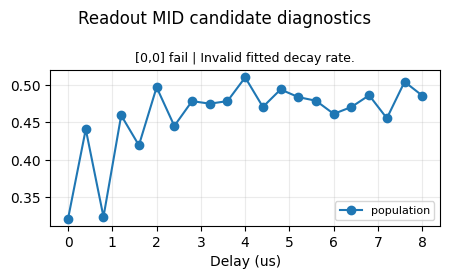

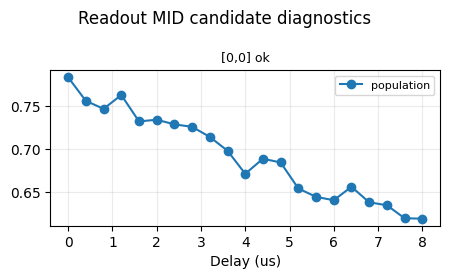

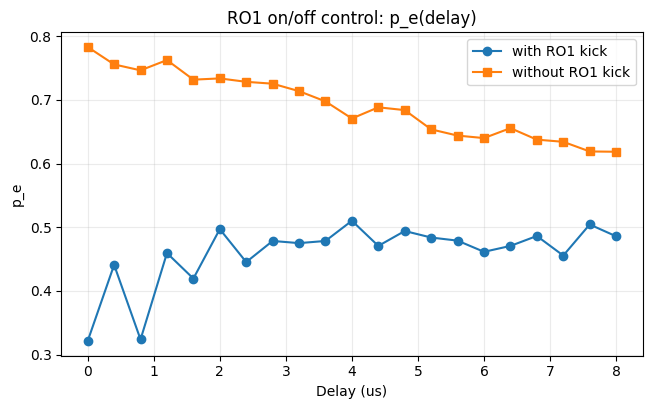

In [3]:
import importlib
import matplotlib.pyplot as plt
import numpy as np

from experiments import readout_mid_sweep
importlib.reload(readout_mid_sweep)

# Standalone fallbacks
if "q" not in globals():
    if "qubits" in globals() and len(qubits) > 0:
        q = qubits[0]
    else:
        raise RuntimeError("q is not defined. Define q (or qubits) before running this cell.")

if "_make_temp_params" not in globals():
    from copy import deepcopy

    def _make_temp_params(qubit, state):
        temp = deepcopy(qubit.parameters)
        for k, v in state.items():
            if hasattr(temp, k):
                setattr(temp, k, v)
        return {qubit.uid: temp}

if "readout_state" not in globals() or readout_state is None:
    readout_state = {
        "readout_resonator_frequency": float(q.parameters.readout_resonator_frequency),
        "readout_amplitude": float(q.parameters.readout_amplitude),
    }

if "mid_delays" not in globals():
    mid_delays = np.linspace(0, 8e-6, 21)


def _extract_mid_analysis_output(workflow_result):
    """Robustly unwrap workflow outputs until a dict containing best_point appears."""
    seen = set()
    queue = [workflow_result]
    seen_attrs = {"output", "analysis_result", "analysis_workflow_result", "analysis_workflow", "result"}

    while queue:
        current = queue.pop(0)
        if current is None:
            continue

        try:
            oid = id(current)
            if oid in seen:
                continue
            seen.add(oid)
        except Exception:
            pass

        if len(seen) > 400:
            raise RuntimeError("Could not extract analysis output: traversal depth exceeded.")

        # Direct payload hit
        if isinstance(current, dict):
            if "best_point" in current and isinstance(current.get("best_point"), dict):
                return current

            # Follow common wrapper keys first
            for k in seen_attrs:
                if k in current and current[k] is not None:
                    queue.append(current[k])
            for value in current.values():
                queue.append(value)
            continue

        if isinstance(current, (list, tuple)):
            queue.extend(current)
            continue

        # Unwrap common reference/task-like attributes
        for attr in seen_attrs:
            if hasattr(current, attr):
                try:
                    value = getattr(current, attr)
                    if value is not None:
                        queue.append(value)
                except Exception:
                    pass

        # Try dictionary-like internals (for reference wrappers).
        d = getattr(current, "__dict__", None)
        if isinstance(d, dict):
            for value in d.values():
                queue.append(value)

    # If we get here, inspect a compact hint for manual debug and fail
    candidates = []
    if hasattr(workflow_result, 'output'):
        candidates.append('output')
    if isinstance(workflow_result, dict):
        candidates.append('dict:' + ','.join(sorted(workflow_result.keys())))
    raise RuntimeError(
        f"Could not extract analysis output containing best_point. Inspect keys: {', '.join(candidates)}"
    )
def _run_mid_single_candidate(*, use_ro1_kick: bool, count: int = 2048):
    base_freq = float(readout_state["readout_resonator_frequency"])

    opts = readout_mid_sweep.experiment_workflow.options()
    opts.do_analysis(True)
    opts.update(False)
    opts.count(int(count))
    opts.use_ro1_kick(bool(use_ro1_kick))
    opts.do_plotting(True)
    opts.do_plotting_diagnostics(True)

    # classifier quality gate
    opts.do_mapping_validation(True)
    opts.do_plotting_mapping_validation(False)
    opts.mapping_validation_min_fidelity(0.95)
    opts.mapping_validation_min_dynamic_range(0.05)

    wf = readout_mid_sweep.experiment_workflow(
        session=session,
        qpu=qpu,
        qubit=q,
        delays=mid_delays,
        readout_resonator_frequencies=np.array([base_freq]),
        sweep_axis="frequency",
        temporary_parameters=_make_temp_params(q, readout_state),
        options=opts,
    )
    run_res = wf.run()
    ana = _extract_mid_analysis_output(run_res)
    return ana


def _candidate_trace(ana: dict):
    item = ana.get("candidate_fit_results", {}).get("0_0", {})
    x = np.asarray(item.get("sweep_points", []), dtype=float) * 1e6
    y = np.asarray(item.get("population", []), dtype=float)
    return x, y, item


def _mapping_row(ana: dict):
    mv = ana.get("mapping_validation", {})
    per = mv.get("per_candidate", []) if isinstance(mv, dict) else []
    return per[0] if per else {}


ana_with = _run_mid_single_candidate(use_ro1_kick=True, count=2048)
ana_without = _run_mid_single_candidate(use_ro1_kick=False, count=2048)

x_with, y_with, item_with = _candidate_trace(ana_with)
x_without, y_without, item_without = _candidate_trace(ana_without)

mv_with = _mapping_row(ana_with)
mv_without = _mapping_row(ana_without)

print("[with RO1] quality:", ana_with.get("quality_flag"), "fit_success:", item_with.get("fit_success"))
print("[with RO1] status:", mv_with.get("status_flag"), "fidelity:", mv_with.get("assignment_fidelity_test"), "dynamic_range:", mv_with.get("pe_dynamic_range"))
print("[without RO1] quality:", ana_without.get("quality_flag"), "fit_success:", item_without.get("fit_success"))
print("[without RO1] status:", mv_without.get("status_flag"), "fidelity:", mv_without.get("assignment_fidelity_test"), "dynamic_range:", mv_without.get("pe_dynamic_range"))

if y_with.size > 0 and y_without.size > 0:
    dr_with = float(np.nanmax(y_with) - np.nanmin(y_with))
    dr_without = float(np.nanmax(y_without) - np.nanmin(y_without))
    print("[contrast] dynamic range with RO1:", dr_with)
    print("[contrast] dynamic range without RO1:", dr_without)
    if dr_without > 0:
        print("[contrast] with/without ratio:", dr_with / dr_without)

fig, ax = plt.subplots(figsize=(7.5, 4.2))
if x_with.size > 0 and y_with.size > 0:
    ax.plot(x_with, y_with, "o-", label="with RO1 kick")
if x_without.size > 0 and y_without.size > 0:
    ax.plot(x_without, y_without, "s-", label="without RO1 kick")
ax.set_xlabel("Delay (us)")
ax.set_ylabel("p_e")
ax.set_title("RO1 on/off control: p_e(delay)")
ax.grid(alpha=0.25)
ax.legend(loc="best")
plt.show()



In [6]:
print(x_with)
print(y_with)
#print(item_with)

[0.  0.4 0.8 1.2 1.6 2.  2.4 2.8 3.2 3.6 4.  4.4 4.8 5.2 5.6 6.  6.4 6.8
 7.2 7.6 8. ]
[0.32128906 0.44091797 0.32373047 0.45947266 0.41943359 0.49707031
 0.4453125  0.47851562 0.47509766 0.47851562 0.51025391 0.47070312
 0.49414062 0.48388672 0.47900391 0.46142578 0.47070312 0.48632812
 0.45556641 0.50439453 0.48583984]


# diagnostics

- $[l_i, a_i]$ 2D sweep 
- `l` : 
- `a` :


아... `RO1` 에 의한 residual photon 잛은 delay일때 보일 수 있음  
    - RO1 직후 cavity ringdown 남아 있으면 RO2 에서 Stark phase / measurement axis 꼬여서 P_e 왜곡...

# SAVE QPU

In [12]:
from laboneq.serializers import save, load, from_dict, from_json, to_dict, to_json
import time

t = time.localtime()
timestamp = time.strftime('%Y%m%d-%H%M', t)

filename = "save_test2"
save(qpu, filename=f"./qpu_parameters/{timestamp}_{filename}")

